In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Adding columns names

In [4]:
col_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 
             'dst_bytes','land', 'wrong_fragment', 'urgent', 'hot', 
             'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
             'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 
             'num_access_files', 'num_outbound_cmds', 'is_host_login', 
             'is_guest_login', 'count', 'srv_count', 'serror_rate', 
             'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 
             'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 
             'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 
             'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
             'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 
             'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 
             'dst_host_srv_rerror_rate', 'label']

## Reading Data

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/PatternRecognition/Assignment2Data/kddcup.data_10_percent.gz', compression='gzip', header=None, names=col_names,sep=',', quotechar='"')
test_df = pd.read_csv('/content/drive/MyDrive/PatternRecognition/Assignment2Data/corrected.gz', compression='gzip', header=None, names=col_names , sep=',', quotechar='"')

In [6]:
train_df=train_df.drop_duplicates(ignore_index=True)

In [7]:
frames = [train_df, test_df]
df = pd.concat(frames,ignore_index=True)

## PreProcessing

# 1- Convert categoric data to numeric

In [8]:
label_encoder = preprocessing.LabelEncoder()
df['protocol_type']= label_encoder.fit_transform(df['protocol_type'])
df['service']= label_encoder.fit_transform(df['service'])
df['flag']= label_encoder.fit_transform(df['flag'])
df['label']= label_encoder.fit_transform(df['label'])

# 2- Check redundant columns

In [9]:
for col in df.columns:
  print(df[col].value_counts())
  print("============")

0        433029
1          8449
4          3711
2          1057
3           865
          ...  
2509          1
6911          1
1609          1
5996          1
11675         1
Name: duration, Length: 3005, dtype: int64
1    250270
0    167375
2     38970
Name: protocol_type, dtype: int64
14    165379
46    127567
22    103291
51     17989
11      8585
       ...  
61        14
59        12
58         2
24         2
47         1
Name: service, Length: 67, dtype: int64
9     335838
5      60290
1      56657
2       1962
4       1297
8        299
10       118
6         84
7         46
3         13
0         11
Name: flag, dtype: int64
0        120775
1032     109142
520       48733
105       21083
508        6266
          ...  
13140         1
2655          1
11563         1
20439         1
5820          1
Name: src_bytes, Length: 3985, dtype: int64
0        303484
146        9028
147        6111
293        5067
105        4439
          ...  
25804         1
15068         1
6332        

# By inspection , num_outbound_cmds has only one value , so it will not have any effect , so drop it

In [10]:
df=df.drop(['num_outbound_cmds'], axis=1)

# Showing correlation matrix

In [11]:
cor=df.corr()

<Axes: >

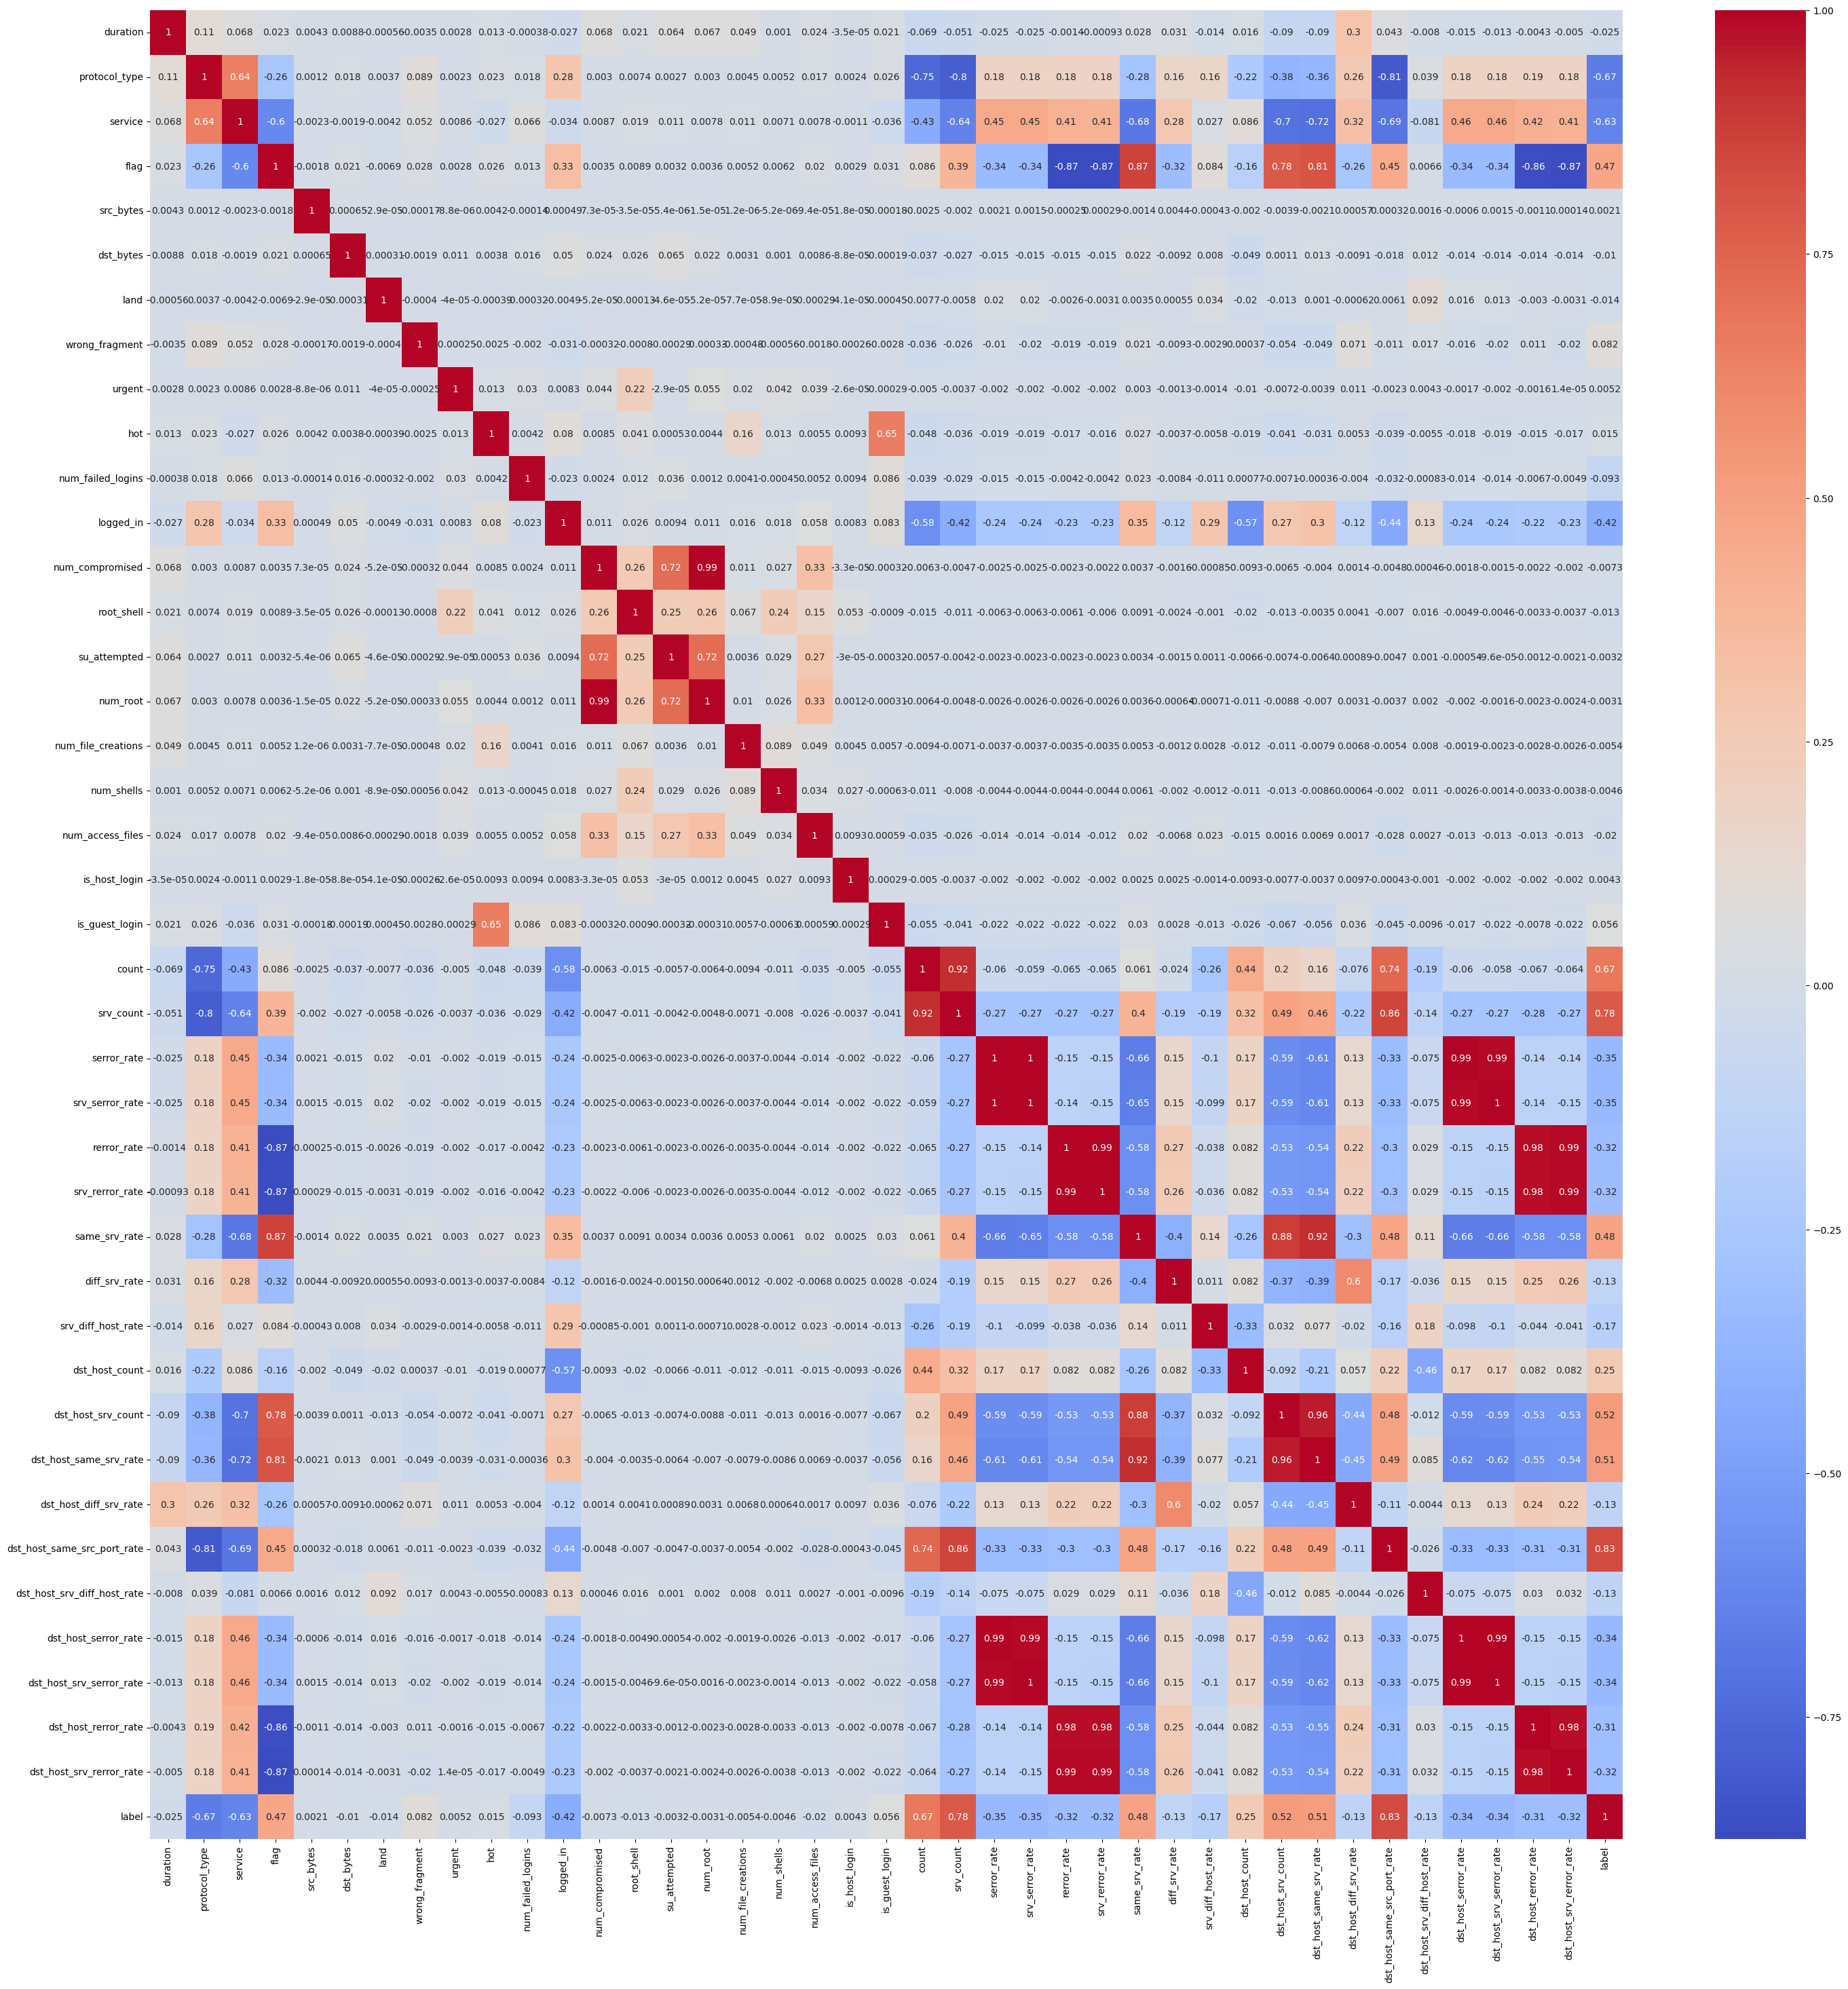

In [12]:
plt.figure(figsize=(35,35))
import seaborn as sns
sns.heatmap(cor, annot = True,cmap= 'coolwarm')

# Some features have nearly equal correlation , so they have same effect , so drop features with corr >= 99%

In [13]:
import warnings
warnings.filterwarnings('ignore')
upper_tri = cor.where(np.triu(np.ones(cor.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= 0.99)]
df = df.drop(columns=to_drop, axis=1)

In [14]:
train_df = df.iloc[:145586]
test_df = df.iloc[145586:]

## Dropping labels column

In [15]:
train_df_unlabeled=train_df.drop(['label'], axis=1)
test_df_unlabeled=test_df.drop(['label'], axis=1)

## As we have large range of numbers in some columns and small range in others , we will scale the data

In [16]:
new_cols=train_df_unlabeled.columns

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_df_unlabeled=scaler.fit_transform(train_df_unlabeled)
test_df_unlabeled=scaler.fit_transform(test_df_unlabeled)

In [18]:
train_df_unlabeled=pd.DataFrame(train_df_unlabeled, columns = new_cols)
test_df_unlabeled=pd.DataFrame(test_df_unlabeled, columns = new_cols)

# Kmeans Class

In [68]:
def euclidean(point, data):
    return np.sqrt(np.sum((point - data)**2, axis=1))

In [139]:
import random
from tqdm import tqdm
class K_Means:
    def __init__(self, k=7, max_iter=300):
        self.k = k
        self.max_iter = max_iter

    def fit(self,data):
      self.centroids = {}
      self.centroids[0]=random.choice(data)
      # Initializing centroids with Kmeans++
      for i in range(1,self.k):
          dists = np.sum([euclidean(centroid, data) for centroid in self.centroids.values()], axis=0)
          dists /= np.sum(dists)
          new_centroid_idx, = np.random.choice(range(len(data)), size=1, p=dists)
          self.centroids[i] = data[new_centroid_idx]

      for iter in tqdm(range(self.max_iter)):
          self.classifications = {} ## This dictionary will contain centroid index as key and the assigned points as values
          self.indeces={}
          for i in range(self.k):
              self.classifications[i] = [] # Empty list for each centroid to append data points in it
              self.indeces[i] = [] # Empty list for each centroid to append index of point in it

          for i,featureset in enumerate(data):
              distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids] ## calculate distance between the point and each centroid
              classification = np.argmin(distances) #get the minimum distance
              self.classifications[classification].append(featureset) ## add data point to the corresponding centroid
              self.indeces[classification].append(i)

          prev_centroids = dict(self.centroids)
          for classification in self.classifications:
              self.centroids[classification] = np.mean(self.classifications[classification],axis=0) ## update centroids according to clusters
          for centroid in self.centroids:
            if np.isnan(self.centroids[centroid]).any():
              print("YA SATEER")
              self.centroids[centroid] = prev_centroids[centroid]

          if prev_centroids.keys() == self.centroids.keys() and all(np.allclose(prev_centroids[k], self.centroids[k]) for k in prev_centroids.keys()):
              break

    def predict(self,data): # takes a data point
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification # return the assigned centroid

In [162]:
km=K_Means(23)
km.fit(train_df_unlabeled.to_numpy())

 10%|█         | 31/300 [12:24<1:47:38, 24.01s/it]


In [163]:
test=[]
for i in range(23):
  row=[]
  for j in tqdm(range(len(km.classifications[i]))):
    index=km.indeces[i][j]
    label=train_df.iloc[index,35]
    row.append(label)
  test.append(row)

100%|██████████| 10730/10730 [00:00<00:00, 46682.03it/s]


In [182]:
from collections import Counter
majority={}
for i in range(23):
  print(Counter(test[i]))
  print(int(list(Counter(test[i]).most_common())[0][0]))
  majority[i]=int(list(Counter(test[i]).most_common())[0][0])

Counter({16: 20213})
16
Counter({14: 17973, 32: 39, 20: 15, 16: 4, 15: 1})
14
Counter({20: 295, 7: 80, 16: 11, 14: 1})
20
Counter({16: 1325, 34: 536, 2: 9, 1: 5, 3: 4, 9: 2, 23: 1})
16
Counter({16: 9265, 1: 84})
16
Counter({14: 9793, 20: 72, 25: 8, 16: 1})
14
Counter({16: 370, 34: 307, 12: 2, 35: 2})
16
Counter({16: 1555, 32: 879, 25: 13, 15: 10, 8: 2, 23: 2, 14: 1})
16
Counter({16: 991, 7: 560, 27: 557, 19: 121, 15: 111, 35: 18, 8: 16, 6: 8, 12: 3, 4: 2, 3: 2, 14: 1, 20: 1, 9: 1, 23: 1})
16
Counter({14: 2274, 16: 3, 20: 2})
14
Counter({16: 3880, 25: 147, 15: 29, 20: 9})
16
Counter({16: 3563, 34: 50, 25: 4, 7: 2, 3: 2, 23: 2, 6: 1, 30: 1, 9: 1})
16
Counter({16: 5228, 25: 9, 15: 6})
16
Counter({25: 715, 20: 12})
25
Counter({16: 4657, 4: 50, 1: 6, 7: 3, 14: 1})
16
Counter({2: 18, 16: 10, 9: 3, 17: 3, 12: 2, 23: 2})
2
Counter({16: 5828, 1: 445, 2: 3, 9: 2, 4: 1})
16
Counter({16: 1891, 19: 85, 27: 84, 14: 14, 25: 9, 7: 6, 20: 4, 6: 3, 23: 2, 15: 1, 30: 1, 8: 1})
16
Counter({14: 10345})
14


In [208]:
majority

{0: 16,
 1: 14,
 2: 20,
 3: 16,
 4: 16,
 5: 14,
 6: 16,
 7: 16,
 8: 16,
 9: 14,
 10: 16,
 11: 16,
 12: 16,
 13: 25,
 14: 16,
 15: 2,
 16: 16,
 17: 16,
 18: 14,
 19: 14,
 20: 16,
 21: 16,
 22: 14}

In [192]:
list(set(majority.values()))

[2, 14, 16, 20, 25]

In [213]:
y_true=[]
y_pred=[]
from IPython.display import clear_output
for index,entry in enumerate(test_df_unlabeled.to_numpy()):
  if test_df.iloc[index,35] in list(set(majority.values())):
    y_true.append(test_df.iloc[index,35])
    y_pred.append(km.predict(entry))
  else:
    continue
y_predict=[]
for i in range(len(y_pred)):
  y_pred[i]=majority[y_pred[i]]

In [214]:
from sklearn.metrics import precision_score,f1_score,recall_score,accuracy_score
micro_precision = precision_score(y_true, y_pred, average='macro')
print("Micro-averaged precision:", micro_precision)
macro_f1 = f1_score(y_true, y_pred, average='macro')
print("Micro-averaged F1 score:", macro_f1)

Micro-averaged precision: 0.9165053707505695
Micro-averaged F1 score: 0.861939718469003


In [215]:
accuracy_score(y_pred,y_true)

0.9973546849734759